# ARIMA for capstone
---


## Step 0. Load in the Data; Format the Dataframe

If you no longer have the 10 pct. data on your computer, follow [this link](https://drive.google.com/file/d/0Bx2SHQGVqWaseDB4QU9ZSVFDY2M/view?usp=sharing). Save the csv somewhere NOT IN THIS REPO. Then load it in using pandas

In [17]:
path = '../00-preprocessing/otr_clean.csv'

In [107]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
plt.style.use('fivethirtyeight')

df = pd.read_csv(path, parse_dates=['date'], infer_datetime_format=True)

df.columns = df.columns.str.lower()

In [108]:
df.columns

Index(['date', 'neighborhood', 'assessor', 'ward', 'land_area', 'owner_name',
       'sale_price', 'sales_code', 'sales_type', 'land_2017', 'land_2018',
       'improvements_2017', 'improvements_2018', 'value_2017', 'value_2018',
       'assessment_2017', 'assessment_2018', 'use_code2', 'tax_type2',
       'homestead_yes', 'homestead_senior', 'homestead_no', 'zip_code',
       'state', 'city', 'address_1', 'qtr', 'month', 'year', 'full_address'],
      dtype='object')

In [109]:
df = df[df.date < '12-01-2017'] #slicing off december

In [110]:
df['houses_sold']=1

In [111]:
cols = ['neighborhood', 'assessor', 'ward', 'land_area', 'owner_name',
       'sale_price', 'sales_code', 'sales_type', 'land_2017', 'land_2018',
       'improvements_2017', 'improvements_2018', 'value_2017', 'value_2018',
       'assessment_2017', 'assessment_2018', 'use_code2', 'tax_type2',
       'homestead_yes', 'homestead_senior', 'homestead_no', 'zip_code',
       'state', 'city', 'address_1', 'qtr', 'month', 'year', 'full_address']

In [112]:
df.drop(cols, 1, inplace = True)

In [113]:
temp = df.groupby(['date']).houses_sold.sum()
temp.head()

date
2000-01-04    1
2000-01-06    1
2000-01-21    1
2000-01-24    1
2000-01-27    1
Name: houses_sold, dtype: int64

Make the `Date` column the index of the dataframe.

In [114]:
dfnew = pd.DataFrame(temp) #dataframe infered date as index, since we grouped by it
dfnew.head()

,houses_sold
date,
2000-01-04,1
2000-01-06,1
2000-01-21,1
2000-01-24,1
2000-01-27,1


In [115]:
dfnew = dfnew.groupby(pd.TimeGrouper(freq='M')).sum()

At this point you should have a timeseries. So now, let's go through the actual workflow:

## Step 1. Visualize the Data

In [116]:
# dfnew.drop('shift_365', 1, inplace = True)

In [117]:
##### boxplot?
# labels = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
#           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')
# xticks(range(1,13),labels, rotation=15)
# xlabel('Month')
# ylabel('Chickenpox cases')
# title('Chickenpox cases in NYC 1931-1971')

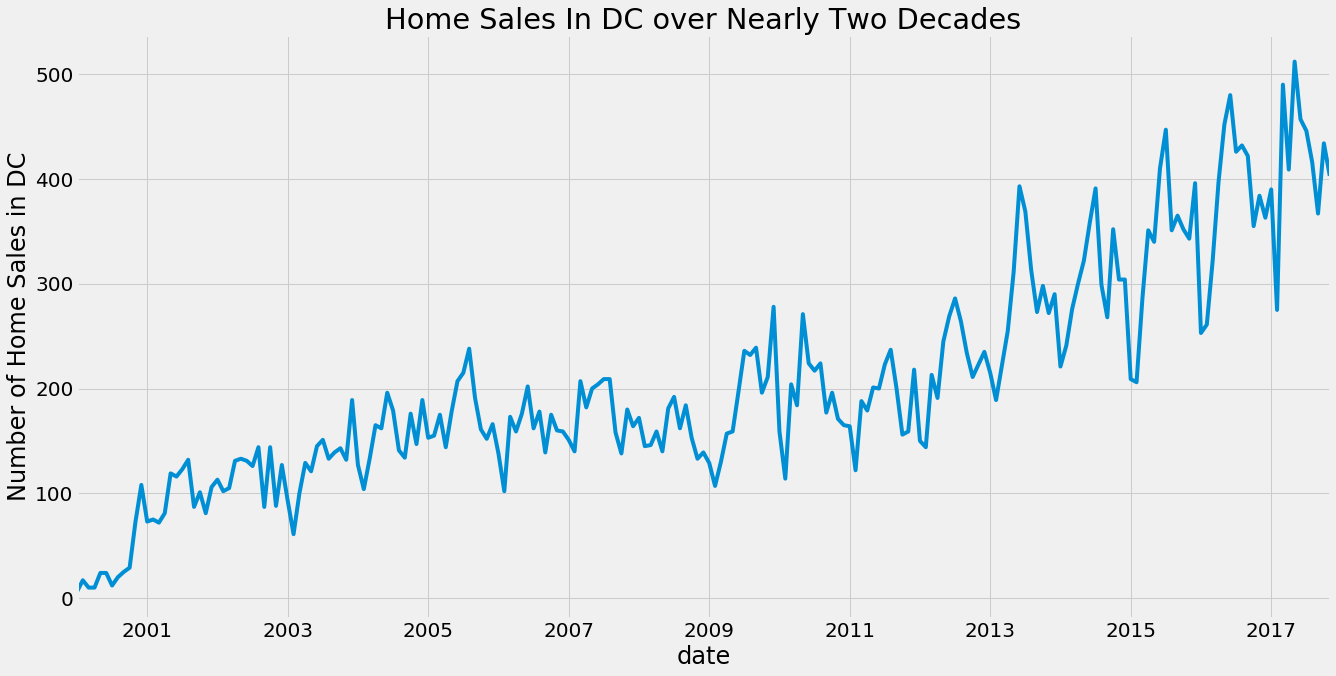

In [118]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 20

viz = dfnew.plot(legend=False)
viz = plt.ylabel('Number of Home Sales in DC')
viz = plt.title('Home Sales In DC over Nearly Two Decades')
viz = plt.show()



## Step 2. Stationize the Data

In [119]:
from statsmodels.tsa.stattools import adfuller #this is depreciated (timestamp: 12/21/2017)

def test_stationarity(timeseries):
    
    '''
    snagged from lecture notebook. My compliments to the chef(s).
    I think the only change I made was to the figsize.
    '''
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(20, 10))

    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in list(dftest[4].items()):
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  # Remove the CWD from sys.path while we load stuff.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  # This is added back by InteractiveShellApp.init_path()


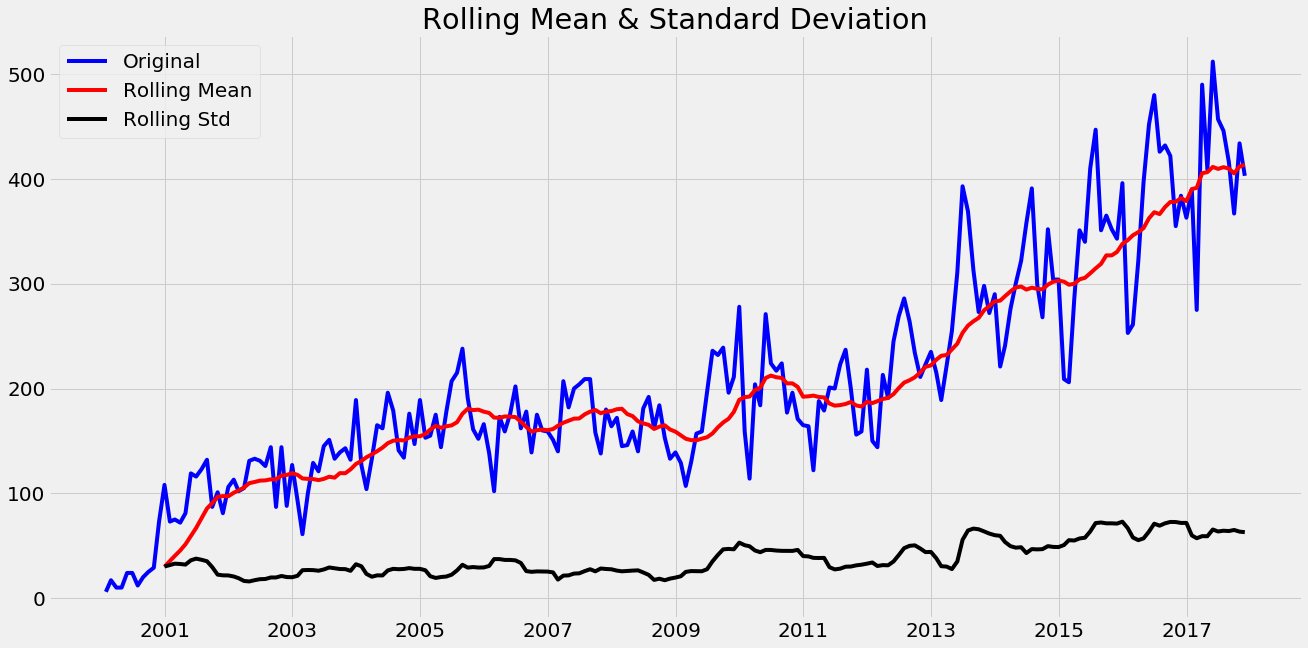

Results of Dickey-Fuller Test:
Test Statistic                   0.415664
p-value                          0.982071
#Lags Used                      13.000000
Number of Observations Used    201.000000
Critical Value (1%)             -3.463309
Critical Value (5%)             -2.876029
Critical Value (10%)            -2.574493
dtype: float64


In [120]:
test_stationarity(dfnew['houses_sold'])


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  # Remove the CWD from sys.path while we load stuff.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  # This is added back by InteractiveShellApp.init_path()


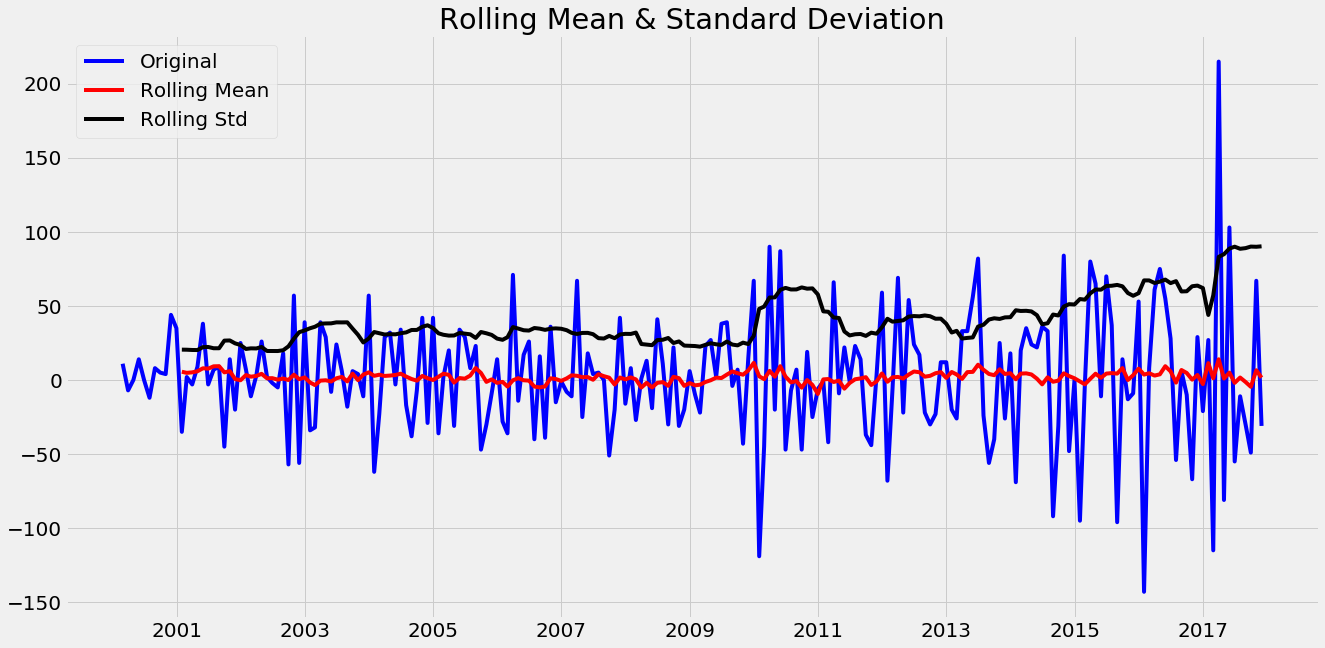

Results of Dickey-Fuller Test:
Test Statistic                  -4.885900
p-value                          0.000037
#Lags Used                      12.000000
Number of Observations Used    201.000000
Critical Value (1%)             -3.463309
Critical Value (5%)             -2.876029
Critical Value (10%)            -2.574493
dtype: float64


In [121]:
dfnew['first_difference'] = dfnew['houses_sold'] - dfnew['houses_sold'].shift(1)  
test_stationarity(dfnew['first_difference'].dropna(inplace=False))

#this helped elimiate the overall trend for the data

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  # Remove the CWD from sys.path while we load stuff.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  # This is added back by InteractiveShellApp.init_path()


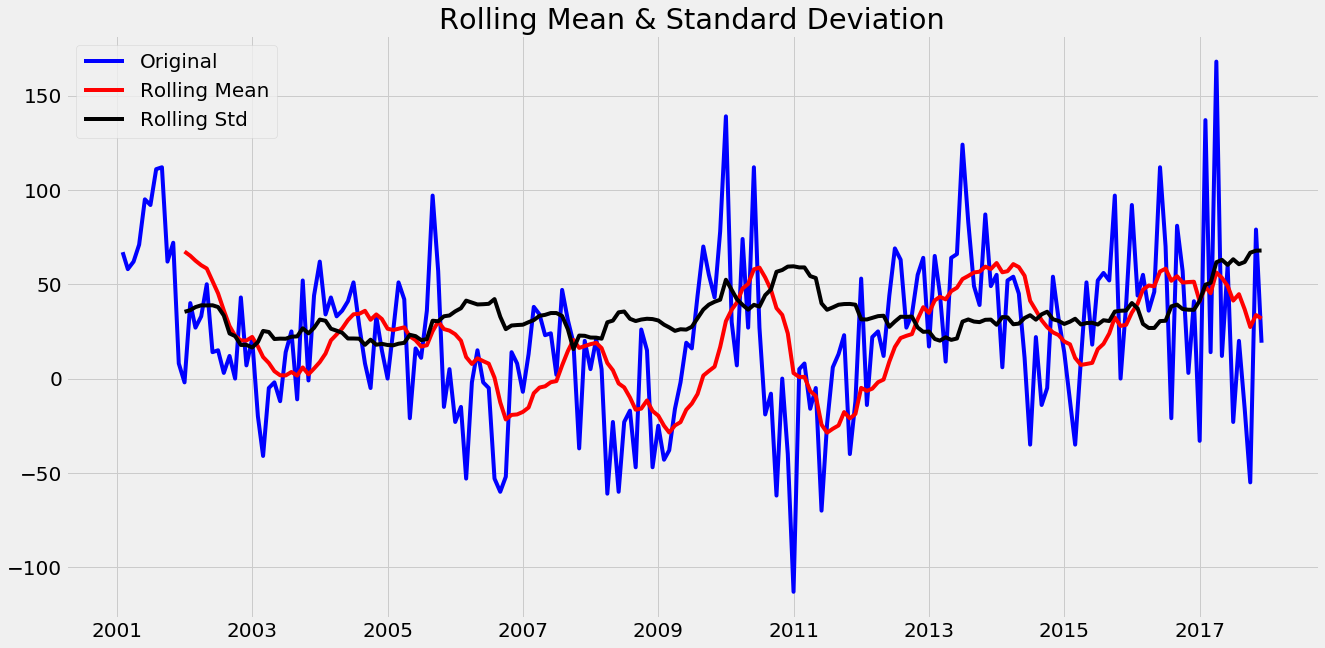

Results of Dickey-Fuller Test:
Test Statistic                  -3.493432
p-value                          0.008157
#Lags Used                      13.000000
Number of Observations Used    189.000000
Critical Value (1%)             -3.465431
Critical Value (5%)             -2.876957
Critical Value (10%)            -2.574988
dtype: float64


In [122]:
dfnew['seasonal_difference'] = dfnew['houses_sold'] - dfnew['houses_sold'].shift(12)  
test_stationarity(dfnew['seasonal_difference'].dropna(inplace=False))

#next step is to take a seasonal difference to remove the seasonality of the data 
#and see how that impacts the stationarity of the data

# the results of my test show that we can account for seasonality, but the std is still trending.

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  # Remove the CWD from sys.path while we load stuff.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  # This is added back by InteractiveShellApp.init_path()


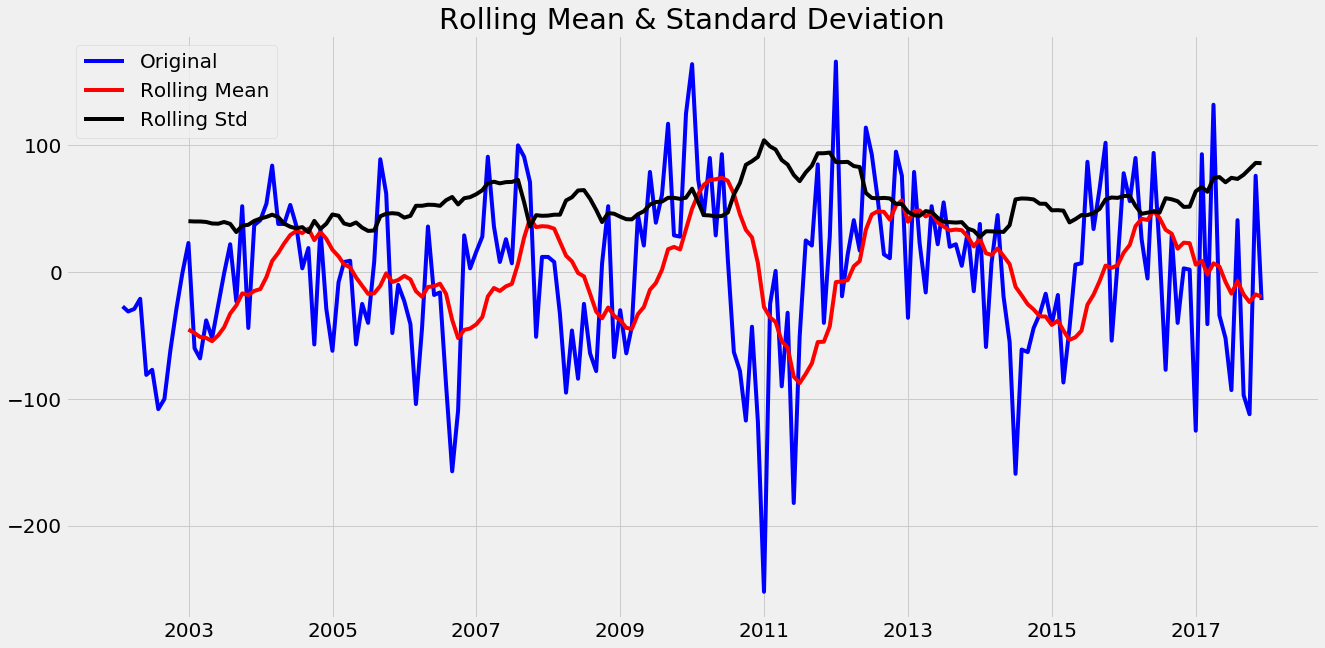

Results of Dickey-Fuller Test:
Test Statistic                  -5.206649
p-value                          0.000009
#Lags Used                      15.000000
Number of Observations Used    175.000000
Critical Value (1%)             -3.468280
Critical Value (5%)             -2.878202
Critical Value (10%)            -2.575653
dtype: float64


In [123]:
dfnew['seasonal_first_difference'] = dfnew['seasonal_difference'] - dfnew['seasonal_difference'].shift(12)  
test_stationarity(dfnew['seasonal_first_difference'].dropna(inplace=False))

#next step is to take a seasonal difference to remove the seasonality of the data 
#and see how that impacts the stationarity of the data

# the results of my test show that we can account for seasonality, but the std is still trending.

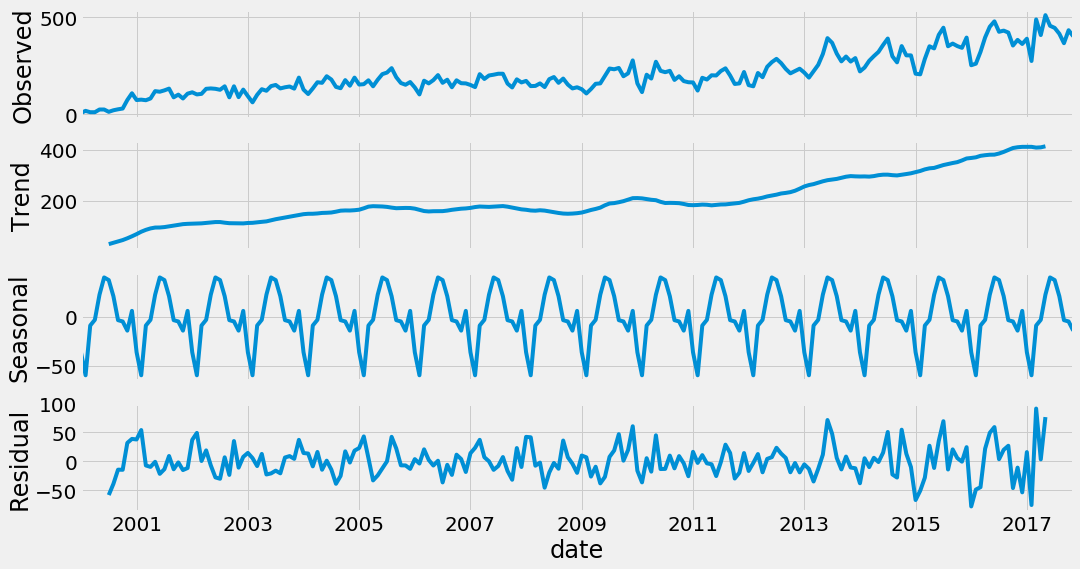

In [124]:
decomposition = seasonal_decompose(dfnew['houses_sold'], freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

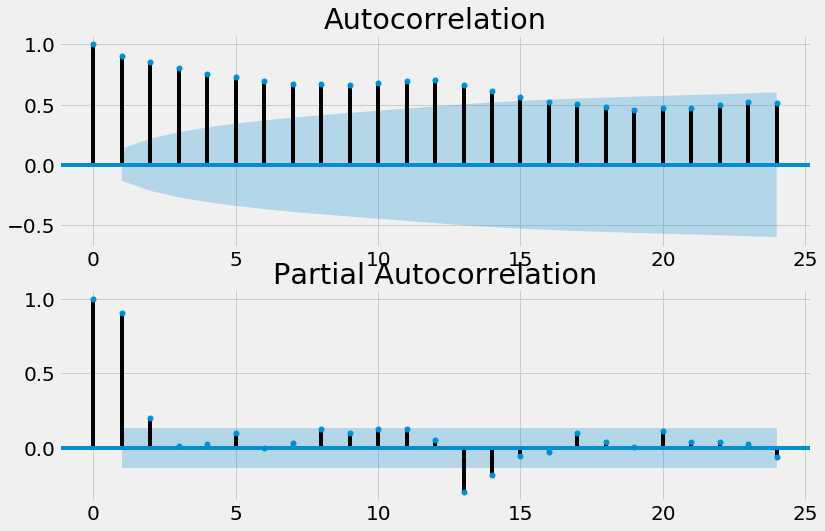

In [128]:
# after confirming stationarity (that we can account for variance and other characteristics of our moving average)
# we need to determine the tuning parameters of the future model 
# by looking at the autocorrelation and partial autocorrelation graphs using statsmodels.
# this will tell us 


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dfnew['houses_sold'], lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dfnew['houses_sold'], lags=24, ax=ax2)

# lags are in days. there seems to be a lot of non-seasonal correlation. nothing weekly, biweekly, monthly.
# i see maybe 18 day patterns, 50 day patterns. it's strange.
# see a 4 day lag, starting at day 3
# some lags are significant (the ones that pop out of the blue 95% confidence level), but they don't occur
# with enough frequency.

## Step 4. Build Your ARIMA Model

In [126]:
import itertools
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


# https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [127]:
#import warnings
#warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dfnew.houses_sold, trend = 'n',
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            print('error')

error
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2590.239361134228
error
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1998.0617559915217
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2121.7823466716013
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2085.3364887565094
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2008.291901928433
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1998.6397942255417
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2698.737014530777
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2413.1222289791094
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2090.4387130468804
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1958.6554024141462
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2097.115643547245
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2040.9988993088457
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1978.4471744846946
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1959.8323197201985
error
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2067.4844091569794
error
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1922.9289161622996
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:2067.3878768390373
ARIMA(0, 1, 0)x(1, 0, 1, 12)

In [129]:
#ARIMA(p, d, q) × (P, D, Q)S

#with p = non-seasonal AR order, d = non-seasonal differencing, q = non-seasonal MA order, 
#P = seasonal AR order, D = seasonal differencing, Q = seasonal MA order, S = time span of repeating seasonal pattern.


mod = sm.tsa.statespace.SARIMAX(dfnew.houses_sold, trend='n', order=(0, 1, 1), seasonal_order=(1, 1, 1, 12))

results = mod.fit()

print(results.summary())


                                 Statespace Model Results                                 
Dep. Variable:                        houses_sold   No. Observations:                  215
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -988.843
Date:                            Fri, 22 Dec 2017   AIC                           1985.687
Time:                                    07:07:55   BIC                           1999.170
Sample:                                01-31-2000   HQIC                          1991.135
                                     - 11-30-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6756      0.048    -13.993      0.000      -0.770      -0.581
ar.S.L12       0.0321      0.118   

## Step 5. Predict the Future
---
For this step, you can decide what values you want to predict. You can predict the first quarter of 2016, or the next three quarters, or the end of 2015. But say explicitly what values you want to predict in the comments.

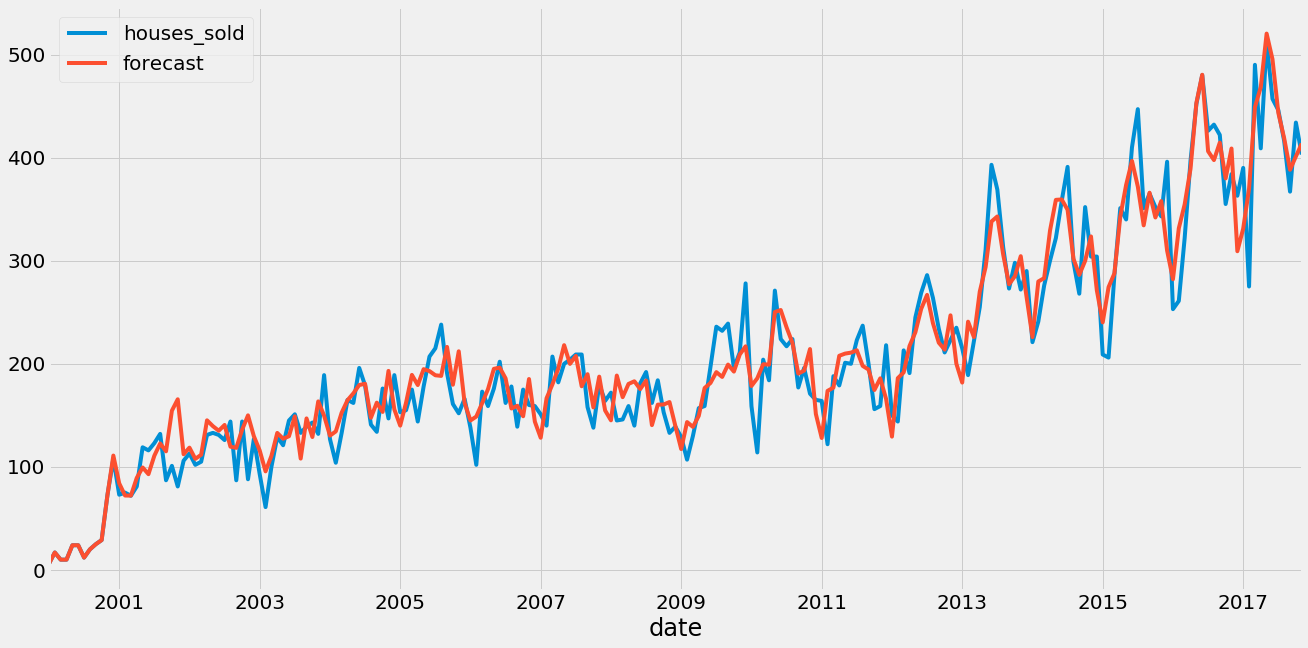

In [142]:
dfnew['forecast'] = list(results.predict(start=1, end=dfnew.shape[0], dynamic= False)) 

dfnew[['houses_sold', 'forecast']].plot(figsize=(20, 10))

#plt.axvline(dfnew.index[204], color='black')
plt.show()



In [187]:
npredict =dfnew.houses_sold['2017-01-31']

In [188]:
npredict

390

In [191]:
pred = results.get_prediction(start=pd.to_datetime('2017'), dynamic=False)
pred_ci = pred.conf_int()

ValueError: Start must be in dates. Got 2017-01-01 00:00:00 | 2017-01-01 00:00:00

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=574.0, right=574.0
  'left=%s, right=%s') % (left, right))


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

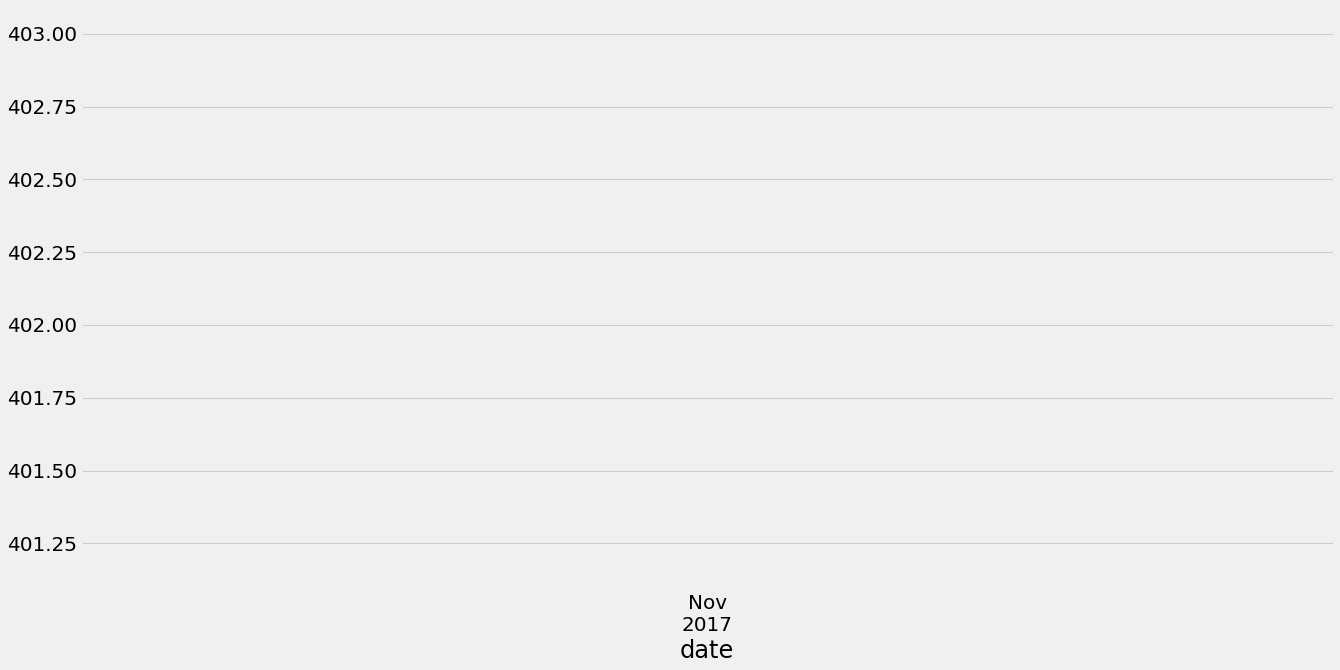

In [190]:
ax = dfnew.houses_sold['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()